In [1]:
from IPython.display import clear_output

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, RMSprop


In [2]:
import os

# Directory where the model will be saved
save_dir = '/model/'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Adversarial training


#### Example of the picture with and without noise

Files already downloaded and verified
Files already downloaded and verified
Original image:


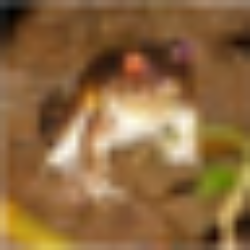

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image, resize


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([AddGaussianNoise(0., 0.05)], p=1)
])

# Load a sample image from CIFAR-10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
dataset2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

random_img_idx = torch.randint(0, 1000, (1,)).item()
test_image1 = dataset[0][0]  # 0 for image part in (image, label) tuple.
test_image1 = resize(test_image1, (250, 250), antialias=None)  # better visualization
test_image = dataset2[0][0]  # 0 for image part in (image, label) tuple.
test_image = resize(test_image, (250, 250), antialias=None)  # better visualization
print("Original image:")
to_pil_image(test_image1)


Augmented Image with Gaussian Noise:


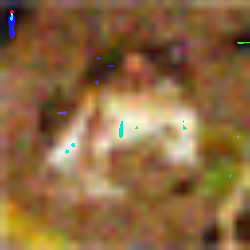

In [4]:
print("Augmented Image with Gaussian Noise:")
to_pil_image(test_image)

#### Training network with adversarial images

In [7]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size(), device=tensor.device) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


# Load and preprocess data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 10),
    transforms.ColorJitter( brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels1x1, out_channels3x3_reduce, out_channels3x3, out_channels5x5_reduce, out_channels5x5, out_channels_pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels1x1, kernel_size=1),
            nn.BatchNorm2d(out_channels1x1),
            nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels3x3_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels3x3_reduce, out_channels3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels3x3),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels5x5_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels5x5_reduce, out_channels5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels5x5),
            nn.ReLU()
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels_pool, kernel_size=1),
            nn.BatchNorm2d(out_channels_pool),
            nn.ReLU()
        )

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4(x)

        outputs = [branch1_out, branch2_out, branch3_out, branch4_out]
        return torch.cat(outputs, 1)

class Cifar10Classifier(nn.Module):
    def __init__(self):
        super(Cifar10Classifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = InceptionModule(32, 16, 16, 32, 4, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception2 = InceptionModule(64, 32, 32, 64, 8, 16, 16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        single_input = False
        if x.ndim == 3:  
            x = x.unsqueeze(dim=0)  
            single_input = True

        x = self.conv1(x)
        x = self.inception1(x)
        x = self.conv2(x)
        x = self.inception2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.log_softmax(x)

        if single_input:
            x = x.squeeze(dim=0)  

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelA = Cifar10Classifier().to(device)
print(modelA)


Cifar10Classifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(32, 4, kernel_size=(1

In [9]:
num_epochs = 50
lr = 1e-4

train_losses = []
val_losses = []
optimizer = RMSprop(modelA.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


print(f'Using device {device}')

Using device cuda


In [11]:
# %%time
optimizers = {
    'Adam': Adam,
    'RMSprop': RMSprop
} 

results = {}
add_noise = AddGaussianNoise(0., 0.05)

for opt_name, opt_func in optimizers.items():
  optimizer = opt_func (modelA.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='abs') 
  for epoch_no in range(num_epochs):

    modelA.train()  

    epoch_weighted_loss = 0
    for batch_X, batch_y in train_loader:
      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)
      batch_X = add_noise(batch_X)

      batch_y_probs = modelA(batch_X)  
      loss = criterion(batch_y_probs, batch_y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_weighted_loss += (len(batch_y)*loss.item())
      
    epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
    train_losses.append(epoch_loss)
    scheduler.step(loss)
    torch.save(modelA.state_dict(),'/model/modelA_'+ str(epoch_no) + ".pth")



    # validation time

    modelA.eval() 
    correctly_labelled = 0

    with torch.no_grad():

      val_epoch_weighted_loss = 0

      for val_batch_X, val_batch_y in val_loader:

        val_batch_X = val_batch_X.to(device)
        val_batch_y = val_batch_y.to(device)
        val_batch_X = add_noise(val_batch_X)

        val_batch_y_probs = modelA(val_batch_X)

        loss = criterion(val_batch_y_probs, val_batch_y)
        val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item() 

    val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
    val_losses.append(val_epoch_loss)

    print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

  print(f'Training complete on device {device}.')

Epoch: 0, train_loss=1.3054008400599162, val_loss=1.1648518008232116. labelled 2954/5000 correctly (59.08% accuracy)
Epoch: 1, train_loss=1.1490667181862726, val_loss=1.0631836915969848. labelled 3102/5000 correctly (62.03999999999999% accuracy)
Epoch: 2, train_loss=1.0551368038495381, val_loss=1.0033205709457398. labelled 3162/5000 correctly (63.239999999999995% accuracy)
Epoch: 3, train_loss=0.9894590854432848, val_loss=0.9512973944187164. labelled 3300/5000 correctly (66.0% accuracy)
Epoch: 4, train_loss=0.9362664343357087, val_loss=0.9264219425201417. labelled 3361/5000 correctly (67.22% accuracy)
Epoch: 5, train_loss=0.8907663690567017, val_loss=0.8733103882312775. labelled 3480/5000 correctly (69.6% accuracy)
Epoch: 6, train_loss=0.8538751609378391, val_loss=0.8477164731025696. labelled 3479/5000 correctly (69.58% accuracy)
Epoch: 7, train_loss=0.8233407132466634, val_loss=0.8152061652183533. labelled 3554/5000 correctly (71.08% accuracy)
Epoch: 8, train_loss=0.7933086960262723, 

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

all_labels = []
all_preds = []

modelA.eval()

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = modelA(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

results_dict["Adversarial_training"] = (accuracy, precision, recall, f1, conf_matrix) 


Accuracy: 0.7917
Precision: 0.8036
Recall: 0.7917
F1 Score: 0.7926
Confusion Matrix:
[[897  13  13  13   4   1   1   6  28  24]
 [ 12 933   3   3   0   3   0   0   8  38]
 [101   4 698  60  36  53  17  21   4   6]
 [ 39   3  50 693  22 136  19  20  10   8]
 [ 58   2  59  98 614  61  10  89   5   4]
 [ 16   2  35 168  13 724   5  29   4   4]
 [ 11   7  47 105   7  48 760   4   7   4]
 [ 17   2  24  30   8  39   0 870   1   9]
 [ 74  18   5  13   1   4   0   2 871  12]
 [ 29  68   3  13   0   4   1   9  16 857]]
